In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType




In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
data_schema = StructType([
    StructField("InvoiceNo", IntegerType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("Country", StringType(), True),
])

In [0]:
streaming_data = (
    spark
    .readStream
    .format("csv")
    .schema(data_schema)
    .option("maxFilesPerTrigger",20)
    .option("header","true")
    .csv("/FileStore/tables/retail")
)

In [0]:

from pyspark.sql.functions import sum, col
customer_aggregates = (
    streaming_data
    .groupBy("CustomerID") 
    .agg(
        sum(col("Quantity")).alias("TotalStocks"),
         sum(col("Quantity") * col("UnitPrice")).alias("TotalValue")
         )
    )

In [0]:
customer_aggregates_result = ( 
                              customer_aggregates
                              .writeStream
                              .outputMode("complete")
                              .format("memory") 
                              .queryName("customer_aggregates")
                              .start()
)

In [0]:
spark.sql("SELECT * FROM customer_aggregates").show()

+----------+-----------+------------------+
|CustomerID|TotalStocks|        TotalValue|
+----------+-----------+------------------+
|   15039.0|        491|1317.7600000000004|
|   16553.0|       1067|1605.1900000000003|
|   13178.0|        388| 709.9999999999999|
|   17812.0|        144|217.55000000000004|
|   16083.0|        384|            337.98|
|   14532.0|         28|             222.6|
|   15002.0|        279| 631.6499999999999|
|   18085.0|         78|303.90000000000003|
|   15070.0|         36|             106.2|
|   17905.0|        172|            394.15|
|   17377.0|        254| 610.0800000000002|
|   13165.0|        496|            354.64|
|   16718.0|        413| 623.7500000000002|
|   12913.0|        146|            417.62|
|   17450.0|        786|           2028.84|
|   15329.0|         -6|             -17.7|
|   15005.0|        266| 470.4100000000001|
|   14491.0|         40|             127.2|
|   14236.0|         38|             189.3|
|   17033.0|        124|        

In [0]:
spark.conf.set("spark.sql.streaming.statefulOperator.checkCorrectness.enabled", "false")

progress_data = (
    customer_aggregates
    .select(current_timestamp().alias("TriggerTime"),
            count("*").alias("RecordsImported"),
            sum("TotalValue").alias("SaleValue")
           )
    .withWatermark("TriggerTime", "2 minutes")  
)

progress_data_query = (
    progress_data
    .writeStream
    .outputMode("update")
    .format("memory")
    .queryName("progress_data")
    .start()
)


In [0]:
spark.sql("SELECT * FROM progress_data").show()

+--------------------+---------------+--------------------+
|         TriggerTime|RecordsImported|           SaleValue|
+--------------------+---------------+--------------------+
|2023-11-12 12:45:...|            949|   748957.0200000012|
|2023-11-12 12:46:...|           1629|  1722763.4700000016|
|2023-11-12 12:46:...|           2320|  2948230.1800000025|
|2023-11-12 12:46:...|           3036|  4366905.1800000025|
|2023-11-12 12:47:...|           3859|   6192471.520000002|
|2023-11-12 12:47:...|           4741|   8321909.331000003|
|2023-11-12 12:48:...|           5673|1.0900742242000002E7|
|2023-11-12 12:48:...|           6568|1.3771209212000005E7|
|2023-11-12 12:48:...|           7338|1.6760316212000007E7|
|2023-11-12 12:49:...|           8167|2.0212073353000008E7|
|2023-11-12 12:49:...|           8987| 2.383502949300001E7|
|2023-11-12 12:50:...|          10009| 2.811186642500001E7|
|2023-11-12 12:50:...|          11194| 3.311791907600001E7|
|2023-11-12 12:50:...|          12504| 3

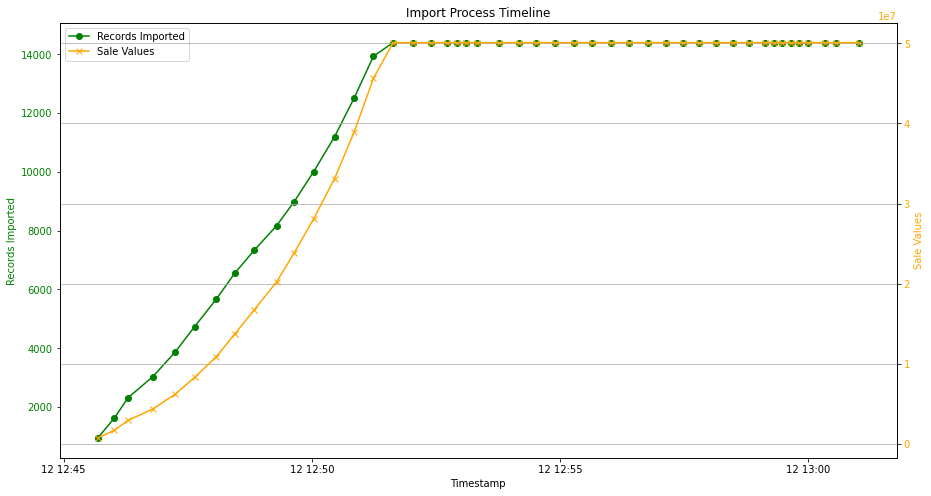

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
progress_data_df = spark.table("progress_data").toPandas()

fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(progress_data_df["TriggerTime"], progress_data_df["RecordsImported"], label="Records Imported", color='green', marker='o')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Records Imported", color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()

ax2.plot(progress_data_df["TriggerTime"], progress_data_df["SaleValue"], label="Sale Values", color='orange', marker='x')
ax2.set_ylabel("Sale Values", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.title("Import Process Timeline")
plt.show()